In [2]:
from gymnasium import Env
from gymnasium.spaces import Discrete, MultiDiscrete 
import numpy as np
import random
import os
from stable_baselines3 import PPO
from stable_baselines3 import DQN

from typing import Optional

from stable_baselines3.common.env_checker import check_env

import matplotlib.pyplot as plt

In [3]:
elevatorNumber = 1
floor_number = 5
floorHeight = 6
elevatorSpeed = 6
elevatorCapacity = 4

floors_for_calls = floor_number - 1

# cikk 5
time_between_floors = 2
stop_time = 2

In [4]:
class ElevatorEnv(Env):
    def __init__(self):
        # 3 actions: DOWN, STOP, UP
        self.action_space = Discrete(3) # available actions

        # ci
        #self.call_on_floors = np.random.randint(0,2,floors_for_calls)
        val = random.randint(1,floors_for_calls)
        self.call_on_floors = np.random.randint(0,1,floors_for_calls)
        self.call_on_floors[val-1] = 1
        # p
        self.position = 0 # random.randint(0, floors_for_calls) #Discrete(5) # 0-4 kozt melyik szinten van a lift
        # v mint velocity : -3, 0 vagy 3 --- 0 1 2
        self.velocity = 1 # random.randint(0, 2) # Discrete(3)
        self.occupacy = 0 # random.randint(0, floors_for_calls) # Discrete(4) # hany ember van a liftben

        #_max_episode_steps = 20

        calls = np.random.randint(2,3,floors_for_calls)
        others = [floor_number, 3 ,elevatorCapacity + 1]
        self.observation_space = MultiDiscrete(np.concatenate((calls, others))) #the state of the env, osszes megfigyeles ebbe
        # f1 ... fn position velocity occupacy ------ time
        

    # transition from one state to another
    def step(self, action):
        # Flag that marks the termination of an episode
        terminated = False # the environment terminating
        truncated = False # the episode truncating
        
        # info
        info = {}
        info['start_pos'] = self.position
        info['start_occ'] = self.occupacy

        # Assert that it is a valid action 
        assert self.action_space.contains(action), "Invalid Action"

        ## apply action
        if action == 0: # accelelrates DOWN
            u = -1
        elif action == 1: # accelerates UP
            u = 1
        elif action == 2: # STOP
            u = 0
        # time events between two floors
        velocity = 3 * u
        self.position = self.position + velocity / 3

        # change occupancy
        if (self.position > 0) and (velocity == 0) and (self.call_on_floors[(int)(self.position-1)] == 1) and (self.occupacy < elevatorCapacity):
            self.occupacy += 1
        elif (self.position == 0) and (velocity == 0):
            self.occupacy = 0
        # change calls accordingly
        for i in range(1, len(self.call_on_floors)+1):
            if self.position == i and velocity == 0 and self.occupacy < elevatorCapacity:
                self.call_on_floors[i-1] = 0
                break

        ## calculate reward
        reward = (float)(- (sum(self.call_on_floors)) - self.occupacy)

        ## arrival of new passangers
        values = list(np.arange(0, elevatorCapacity+1))
        probs = [0.6875, 0.0625, 0.09375, 0.09375, 0.0625]
        e = np.random.choice(values, 1, p=probs)
        for i in range(1, len(self.call_on_floors)+1):
            if e == i:
                self.call_on_floors[i-1] = 1
                break

        if velocity == -3:
            self.velocity = 0
        elif velocity == 0:
            self.velocity = 1
        elif velocity == 3:
            self.velocity = 2

        ## end of action
        if reward == 0:
            terminated = True

        ## 
        if self.position > floors_for_calls:
            truncated = True
            terminated = False
            reward -= 100
            self.position = floors_for_calls
        elif self.position < 0:
            truncated = True
            terminated = False
            reward -= 100
            self.position = 0

        #############################
        if info.get('action') is not None:
            if action == 2:
                if info['action'] != 1:
                    reward -= -100
                    truncated = True
                    terminated = False
            if info['action'] == 2 and action != 0:
                reward -= -100
                truncated = True
                terminated = False
        '''
        else:
            if action == 2:
                reward -= 100
                truncated = True
                terminated = False
        '''

        info['end_pos'] = self.position
        info['end_occ'] = self.occupacy
        info['action'] = action
        info['reward'] = reward

        stuff = np.array([self.position, self.velocity, self.occupacy]).astype(int)
        rta = np.concatenate((self.call_on_floors, stuff))
        # Return step information
        return rta, reward, terminated, truncated, info
       
    def render(self):
        pass

    def reset(self, seed: Optional[int] = None):
        info = {}
        
        val = random.randint(1,floors_for_calls)
        self.call_on_floors = np.random.randint(0,1,floors_for_calls)
        self.call_on_floors[val-1] = 1
        #self.call_on_floors = np.random.randint(0,2,floors_for_calls)

        self.position = 0 #random.randint(0, 4)
        self.velocity = 1 #random.randint(0, 2)
        self.occupacy = 0 #random.randint(0, 4)

        stuff = np.array([self.position, self.velocity, self.occupacy]).astype(int)
        rta = np.concatenate((self.call_on_floors, stuff))
        return rta, info

In [5]:
env = ElevatorEnv()
check_env(env, warn=True)

In [6]:
###### n-times to the ground floor with passangers

def add_wait_time(waiting_times, time, obs):
    for i in range(0, len(obs[0])-3): 
        if obs[0][i] == 1:
            waiting_times[i] += time
        return waiting_times

def iterate_over(model, arrival_number):
    env = model.get_env()
    obs = env.reset()

    waiting_times = [0] * (len(obs[0])-3)
    waits = []
    
    system_times = []
    sys_times = []

    arrivals = 0

    while arrivals != arrival_number:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)

        if action == 1: # UP
            waiting_times = add_wait_time(waiting_times, time_between_floors, obs)
            if len(system_times) > 0:
                system_times = [x + time_between_floors for x in system_times]
        elif action == 0: # DOWN
            waiting_times = add_wait_time(waiting_times, time_between_floors, obs)
            if len(system_times) > 0:
                system_times = [x + time_between_floors for x in system_times]
        elif action == 2: # STOP
            waiting_times = add_wait_time(waiting_times, stop_time, obs)
            if len(system_times) > 0:
                system_times = [x + time_between_floors for x in system_times]
            floor = obs[0][-3]
            if floor == 0: # letesz
                if info[0]['start_occ'] > 0:
                    arrivals += 1
                    sys_times.append(np.mean(system_times))
                    system_times = []
            else: # felvesz
                if info[0]['start_occ'] < info[0]['end_occ']:
                    system_times.append(waiting_times[floor - 1])
                    waits.append(waiting_times[floor - 1])
                    waiting_times[floor - 1] = 0
    return np.mean(sys_times), np.mean(waits)

TESTING - PPO


In [379]:
del model_PPO

In [376]:
model_PPO = PPO("MlpPolicy", env, verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [377]:
model_PPO.learn(total_timesteps=100000)

Logging to Training\Logs\PPO_201
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.88     |
|    ep_rew_mean     | -121     |
| time/              |          |
|    fps             | 1572     |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 13.2        |
|    ep_rew_mean          | -138        |
| time/                   |             |
|    fps                  | 1106        |
|    iterations           | 2           |
|    time_elapsed         | 3           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016105656 |
|    clip_fraction        | 0.191       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.0135    

In [378]:
system_t = []
wait_t = []
for i in range (0, 10):
    system_time, wait_time = iterate_over(model_PPO, 10)
    system_t.append(system_time)
    wait_t.append(wait_time)

print()
print(np.mean(system_t), "mean system time")
print(np.mean(wait_t), "mean wait time")


8.696666666666667 mean system time
2.7346453546453544 mean wait time


PPO -val végzett mérésekhez


In [ ]:
del model_PPO

In [416]:

#model_PPO = PPO("MlpPolicy", env, learning_rate=0.0003, n_steps=2048, gamma=0.99, verbose=0) # alapértelmezett
#model_PPO = PPO("MlpPolicy", env, learning_rate=0.003, n_steps=2048, gamma=0.99, verbose=0) # magasabb tanulasai rata
#model_PPO = PPO("MlpPolicy", env, learning_rate=0.0003, n_steps=4096, gamma=0.99, verbose=0) # tobb lepes
model_PPO = PPO("MlpPolicy", env, learning_rate=0.003, n_steps=4096, gamma=0.99, verbose=0) # magasabb tanulasi rata es tobb lepes

maxi = 25
learning_steps = 10000

system_t = []
wait_t = []

for i in range (0, maxi):
    model_PPO.learn(total_timesteps=learning_steps)
    print(i, "learned")
    system_time, wait_time = iterate_over(model_PPO, 100)
    system_t.append(system_time)
    wait_t.append(wait_time)
    print(i, "iterated")

elevator_path = os.path.join('Training', 'Models-4', 'PPO-x') 
model_PPO.save(elevator_path)

print()
print(np.mean(system_t), "mean system time")
print(np.mean(wait_t), "mean wait time")

xarray2 = []
for i in range(1, maxi + 1):
    xarray2.append(learning_steps * i)

0 learned
0 iterated
1 learned
1 iterated
2 learned
2 iterated
3 learned
3 iterated
4 learned
4 iterated
5 learned
5 iterated
6 learned
6 iterated
7 learned
7 iterated
8 learned
8 iterated
9 learned
9 iterated
10 learned
10 iterated
11 learned
11 iterated
12 learned
12 iterated
13 learned
13 iterated
14 learned
14 iterated
15 learned
15 iterated
16 learned
16 iterated
17 learned
17 iterated
18 learned
18 iterated
19 learned
19 iterated
20 learned
20 iterated
21 learned
21 iterated
22 learned
22 iterated
23 learned
23 iterated
24 learned
24 iterated

10.721947619047619 mean system time
2.211922501897383 mean wait time


In [393]:
print(system_t)
print(min(system_t))

[30.473077922077923, 16.355, 11.973333333333333, 9.18, 9.76, 8.543333333333333, 8.555, 9.046666666666667, 8.966666666666667, 8.646666666666667, 8.376666666666667, 8.93, 8.74, 9.308333333333332, 9.563333333333333, 10.35, 10.163333333333334, 10.67, 10.428333333333333, 10.196666666666665, 10.12, 10.841666666666665, 10.426666666666666, 10.093333333333332, 10.755]
8.376666666666667


In [ ]:
'''
system_t = []
wait_t = []

ts = 40000

for i in range (0, 5):
    model_PPO.learn(total_timesteps=ts)
    system_time, wait_time = iterate_over(model_PPO, 100)
    system_t.append(system_time)
    wait_t.append(wait_time)
    print(i)

print()
print(np.mean(system_t), "mean system time")
print(np.mean(wait_t), "mean wait time")

xarray = range (1, 11)

xarray2_last = xarray2[-1]
xarray2 = []
xarray2.append(xarray2_last + ts)
for i in xarray:
    if i != 1:
        xarray2.append(xarray2[-1] + ts)
'''

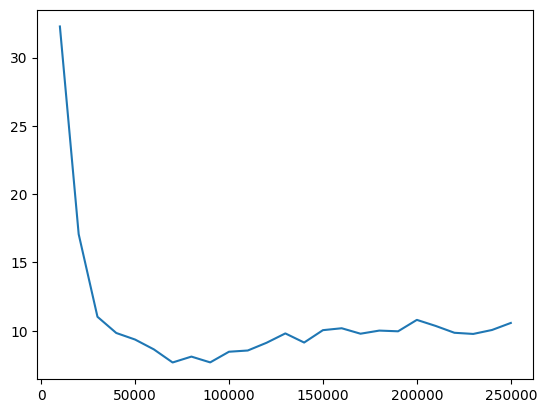

7.673333333333334 32.279357142857144
[32.279357142857144, 17.069333333333333, 11.02, 9.833333333333332, 9.353333333333332, 8.633333333333333, 7.673333333333334, 8.103333333333332, 7.68, 8.46, 8.55, 9.116666666666667, 9.801666666666668, 9.133333333333333, 10.04, 10.18, 9.78, 10.008333333333333, 9.956666666666667, 10.793333333333333, 10.35, 9.848333333333334, 9.763333333333332, 10.053333333333335, 10.568333333333335]


In [417]:
# system time

xpoints = np.array(xarray2)
ypoints = np.array(system_t)

plt.plot(xpoints, ypoints)
plt.show()

print (min(system_t), max(system_t))
print(system_t)

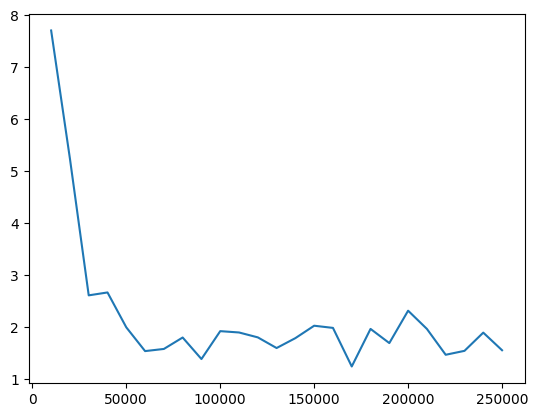

1.2475247524752475 7.709090909090909
[7.709090909090909, 5.243589743589744, 2.6153846153846154, 2.6711409395973154, 2.0, 1.5433070866141732, 1.5846153846153845, 1.8045112781954886, 1.390625, 1.927007299270073, 1.9014084507042253, 1.8072289156626506, 1.6022727272727273, 1.7926829268292683, 2.03125, 1.9894736842105263, 1.2475247524752475, 1.97, 1.697560975609756, 2.320388349514563, 1.97, 1.472636815920398, 1.5480769230769231, 1.898477157360406, 1.5598086124401913]


In [418]:
# wait time for elevator

xpoints = np.array(xarray2)
ypoints = np.array(wait_t)

plt.plot(xpoints, ypoints)
plt.show()

print (min(wait_t), max(wait_t))
print(wait_t)

In [420]:
print( xarray2 )
print("system time")
print( (np.around(system_t,2)) )
print("wait time for elevator")
print( (np.around(wait_t,2)) )


[10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000]
system time
[32.28 17.07 11.02  9.83  9.35  8.63  7.67  8.1   7.68  8.46  8.55  9.12
  9.8   9.13 10.04 10.18  9.78 10.01  9.96 10.79 10.35  9.85  9.76 10.05
 10.57]
wait time for elevator
[7.71 5.24 2.62 2.67 2.   1.54 1.58 1.8  1.39 1.93 1.9  1.81 1.6  1.79
 2.03 1.99 1.25 1.97 1.7  2.32 1.97 1.47 1.55 1.9  1.56]


DQN 

In [ ]:
del model_DQN

In [433]:

#model_DQN = DQN("MlpPolicy", env, learning_rate=0.0001, exploration_initial_eps=1, exploration_final_eps=0.05, verbose=0) # alapértelmezett
model_DQN = DQN("MlpPolicy", env, learning_rate=0.38, exploration_initial_eps=0.8, exploration_final_eps=0.89, verbose=0) # cikkben

maxi = 25
learning_steps = 50000

system_t = []
wait_t = []
for i in range (0, maxi):
    model_DQN.learn(total_timesteps=learning_steps)
    print(i,  "learned")
    system_time, wait_time = iterate_over(model_DQN, 100)
    system_t.append(system_time)
    wait_t.append(wait_time)
    print(i, "iterated")

elevator_path = os.path.join('Training', 'Models-4', 'DQN-x') 
model_DQN.save(elevator_path)

print()
print(np.mean(system_t), "mean system time")
print(np.mean(wait_t), "mean wait time")

xarray2 = []
for i in range(1, maxi + 1):
    xarray2.append(learning_steps * i)

0 learned
0 iterated
1 learned
1 iterated
2 learned
2 iterated
3 learned
3 iterated
4 learned
4 iterated
5 learned
5 iterated
6 learned
6 iterated
7 learned
7 iterated
8 learned
8 iterated
9 learned
9 iterated
10 learned
10 iterated
11 learned
11 iterated
12 learned
12 iterated
13 learned
13 iterated
14 learned
14 iterated
15 learned
15 iterated
16 learned
16 iterated
17 learned
17 iterated
18 learned
18 iterated
19 learned
19 iterated
20 learned
20 iterated
21 learned
21 iterated
22 learned
22 iterated
23 learned
23 iterated
24 learned
24 iterated

90.92706841739084 mean system time
11.966423423271065 mean wait time


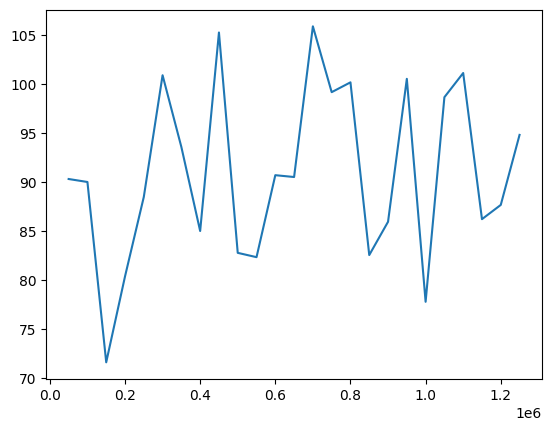

71.63783583959899 105.92535624328782
[90.34274644364352, 90.03982476067031, 71.63783583959899, 80.40102999941234, 88.50859479409479, 100.93290997890998, 93.60730808080808, 85.03823759900231, 105.29484211813224, 82.80800600740848, 82.36721026266997, 90.73304548650523, 90.54617764098646, 105.92535624328782, 99.20550996225998, 100.20755775784095, 82.58278011530955, 85.97799486908, 100.56578725634532, 77.81311802086802, 98.69141940283659, 101.15971493521492, 86.24646662487838, 87.69893494740552, 94.8443012876013]


In [434]:
# system time

xpoints = np.array(xarray2)
ypoints = np.array(system_t)

plt.plot(xpoints, ypoints)
plt.show()

print (min(system_t), max(system_t))
print(system_t)

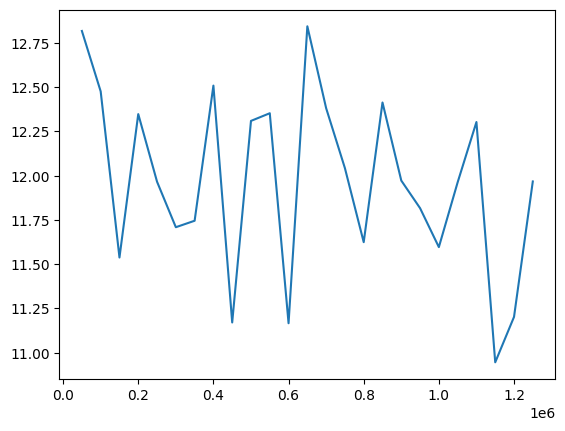

10.945054945054945 12.84297520661157
[12.816666666666666, 12.475285171102662, 11.536992840095465, 12.347140039447732, 11.965183752417795, 11.708185053380783, 11.74468085106383, 12.508064516129032, 11.170046801872076, 12.308668076109937, 12.351966873706004, 11.165735567970206, 12.84297520661157, 12.380634390651085, 12.04159445407279, 11.623604465709729, 12.412631578947368, 11.971602434077079, 11.815699658703071, 11.59578947368421, 11.961871750433275, 12.302405498281788, 10.945054945054945, 11.201438848920864, 11.966666666666667]


In [435]:
# wait time for elevator

xpoints = np.array(xarray2)
ypoints = np.array(wait_t)

plt.plot(xpoints, ypoints)
plt.show()

print (min(wait_t), max(wait_t))
print(wait_t)

In [437]:

print( xarray2 )
print("system time")
print( (np.around(system_t,2)) )
print("wait time for elevator")
print( (np.around(wait_t,2)) )


[50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000, 850000, 900000, 950000, 1000000, 1050000, 1100000, 1150000, 1200000, 1250000]
system time
[ 90.34  90.04  71.64  80.4   88.51 100.93  93.61  85.04 105.29  82.81
  82.37  90.73  90.55 105.93  99.21 100.21  82.58  85.98 100.57  77.81
  98.69 101.16  86.25  87.7   94.84]
wait time for elevator
[12.82 12.48 11.54 12.35 11.97 11.71 11.74 12.51 11.17 12.31 12.35 11.17
 12.84 12.38 12.04 11.62 12.41 11.97 11.82 11.6  11.96 12.3  10.95 11.2
 11.97]


DQN

In [7]:
elevator_path = os.path.join('Training', 'Models-4', 'DQN-2') 
#model_DQN.save(elevator_path)
model = DQN.load(elevator_path, env)

In [33]:
model.learn(total_timesteps=1000000)

In [35]:
system_time, wait_time = iterate_over(model, 100)

print(np.around(system_time), "mean system time")
print(np.around(wait_time), "mean wait time")

77.0 mean system time
9.0 mean wait time


x

In [355]:
# STATISTICS

model = model_PPO
env = model.get_env()
obs = env.reset()

arrival_number = 100
arrivals = 0

it = 0
its = []

up = 0
down = 0
stop = 0
pickup = 0

rewards = []

while arrivals != arrival_number:
    action, _states = model.predict(obs)
    obs, reward, done, info = env.step(action)

    rewards.append(reward[0])

    it += 1
    if action == 1:
        up += 1
    if action == 0:
        down += 1
    if action == 2: # STOP
        stop +=1
        floor = obs[0][-3]
        if floor == 0: # arrival
            if info[0]['start_occ'] > 0:
                arrivals += 1
                its.append(it)
                it = 0
        else: # pick up passanger
            if (info[0]['start_occ'] <  info[0]['end_occ']):
                pickup += 1

print(up, down, stop)
print(np.mean(its))
print(pickup)

234 234 351
8.19
152


In [356]:
values, counts = np.unique(np.array(rewards), return_counts=True)
print(values)
print(counts)

[-6. -5. -4. -3. -2. -1.  0.]
[  2  31  85 274 343  80   4]
